# Neural Networks
Noah Armsworthy
September 2nd, 2022

In this notebook I will create a build-able neural network classes and functions using only basic python, abstract classes, and numpy. I will also be graphing libraries to help visualize data and model performance. I will not be going too deep into the math of the functions, their derivatives and the back propagation chain rule but will try to share resources on those topics as they come up. 

In [257]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

We will be using the keras library to easily load the MNIST dataset, because of storage limitations from gitlab.

The MNIST dataset contains tens of thousands of handwritten numbers from 0-9 in 28x28 pixel images. We're going to create a neural network that can effectively learn from these images and classify ones it has never seen.

The dataset contains 60,000 training samples and 10,000 test samples.

In [258]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#Here we can see the shapes of our dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


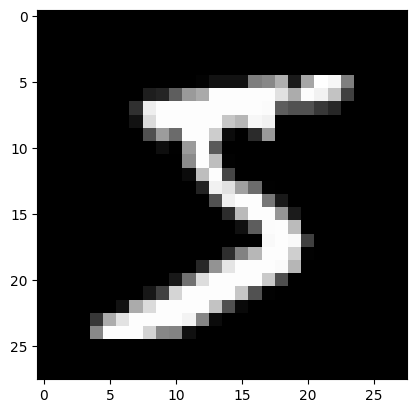

Target value: 5


In [259]:
'''
A function to print the image of a given MNIST sample and it's target value.
'''  
def printDIGIT(data, target, index):
    plt.imshow(data[index], cmap=plt.get_cmap('gray'))
    plt.show()
    print('Target value:', target[index])

#Here we can get a look at the first training sample
printDIGIT(X_train, y_train, 0)

## Neural Network architecture 
The NN we are going to make today is referred to as a Multi-Layer Perceptron, a "perceptron" being a single neuron or "node". The benefit of compounding multiple layers of nodes is so that we can model difficult problems by sequentially adding layers of complexity to the solution as we build it. Nodes will take in weighted inputs and apply its activation function to calculate which neurons are 'activated' and the strength of its contribution.

Grant Sanderson does an excellent job explaining the full fundamentals of Neural Networks here: https://www.3blue1brown.com/lessons/neural-networks <br>
This is another great resource for NN architecture: https://machinelearningmastery.com/neural-networks-crash-course/

# Activation functions
The idea behind the activation functions of the nodes of a neural network is the ability to transform the original input of a linear combination of all the relevant variables within the data into a non-linear function that best describes the predictions, regression or classification.

Three popular functions for doing this are the Logistic (Sigmoid), Hyperbolic Tangent (Tanh) and, more recently, Rectified Linear Unit (ReLU) functions. If you look at the graphs below and imagine they are the shape outline for the "puzzle pieces" of our network, you can see how we might create some 'wiggle' in our results. 'Wiggle' meaning our non-linearity. :) 

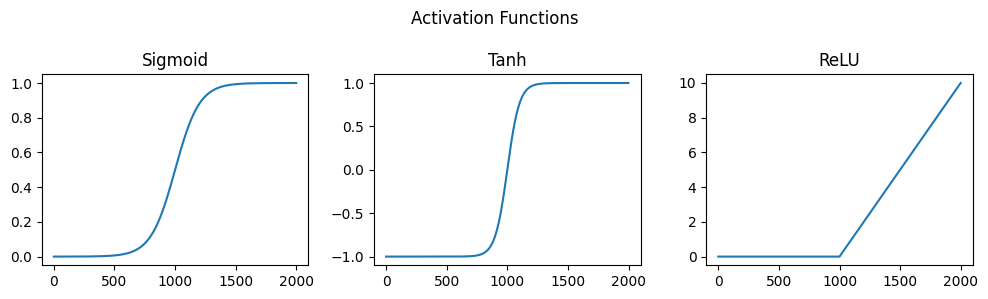

In [260]:
#Visualizing the activation functions
titles = ["Sigmoid", "Tanh", "ReLU"]
xrange = np.arange(-10, 10, 0.01)
functions = (1/(1 + np.exp(-xrange)), np.tanh(xrange), np.maximum(0.0, xrange))
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(0, len(ax)):
    ax[i].set_title(titles[i])
    ax[i].plot(functions[i])
fig.suptitle("Activation Functions")
fig.tight_layout()

The activation functions themselves create an asymptote(s) that contain the data within a threshold. Sigmoid is between [0.0,1.0] and Tanh [-1.0,1.0]. **All** the values given are scaled to fit within these constraints (even if they are already within) so that larger values will be near the thresholds and smaller ones closer to the middle. ReLU only corrects values below zero to 0. This lets our strong positive weights stick around for sensitivity. It also corrects the vanishing gradient problem, so it is the very useful for robust deep networks. 

Additional information: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

In [261]:
'''Abstract method library for activations to maintain structure signature 
and allow for easy forward and backward calls'''
import abc

class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        pass

    @abc.abstractmethod
    def backward(self, grad, original_input):
        pass

'''
Sigmoid https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
'''
class Sigmoid(Activations):
    def forward(self, x):
        return 1/(1 + np.exp(-x))
    
    def backward(self, grad, original_input):
        x = self.forward(original_input)
        return grad * ( x * (1 - x))
    
    def __call__(self, x, mode=None):
        return self.forward(x)
'''
Tanh https://blogs.cuit.columbia.edu/zp2130/derivative_of_tanh_function/
'''
class Tanh(Activations):
    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, grad, original_input):
        return grad * (1 - np.tanh(original_input)**2)
    
    def __call__(self, x, mode=None):
        return self.forward(x)

'''
ReLU https://deepai.org/machine-learning-glossary-and-terms/relu
'''
class ReLU(Activations):
    def forward(self, x):
        return np.maximum(0.0,x)

    def backward(self, grad, original_input):
        x = original_input
        return grad * (x>0.0)

    #Allows for easy calling forward using only ReLU(x)
    def __call__(self, x, mode=None):
        return self.forward(x)

In [262]:
'''We can easily take a look at how these activation functions would affect incoming data.
For our sample data:
First row we have a value within [0.0,1.0], a value slightly larger than 1 and a value much larger than 1.
Second row we have a value within [-1.0,1.0], a value slightly less than 0.0 and a value much less than 0.0 '''
x = np.array([[0.8, 1.5, 15.0], 
              [-0.2, -5.0, -15.0]])

print('Original Input:\n', x)
#The empty parenthesis here is to initialize the class, then (x) calls the forward function. 
print('Sigmoid output scales all values to within [0, 1]:\n', np.array_str(Sigmoid()(x), precision=4, suppress_small=True))
print('Tanh output scales all values to within [-1, 1]:\n', np.array_str(Tanh()(x), precision=4, suppress_small=True))
print('ReLU output only sets negative values to 0:\n', np.array_str(ReLU()(x), precision=4, suppress_small=True))

Original Input:
 [[  0.8   1.5  15. ]
 [ -0.2  -5.  -15. ]]
Sigmoid output scales all values to within [0, 1]:
 [[0.69   0.8176 1.    ]
 [0.4502 0.0067 0.    ]]
Tanh output scales all values to within [-1, 1]:
 [[ 0.664   0.9051  1.    ]
 [-0.1974 -0.9999 -1.    ]]
ReLU output only sets negative values to 0:
 [[ 0.8  1.5 15. ]
 [ 0.   0.   0. ]]


As you can see, for Sigmoid and Tanh, the value within the constraints is still altered to closer to the mid-point so that the values scaled down from outside the constraints can be represented by the higher value close to the asymptote. 

# SoftMax

In [263]:
#Soft max takes in a sample of values and scales them to
#Values between 0 and 1, making them interpretable as probabilities
def softMax(x):
  #Currently made to accept an np array of arrays to process mutliple samples
  return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True) 

In [264]:
#Testing
x = np.array([[2.0,   0.8], 
              [-0.4,  10.0]])

#ReLU will convert negative values to 0.0
relu = ReLU()
relX = relu(x)
print('Result after a ReLU:\n', relX)

#While implementing softmax, you can shift your input. 
#This does not affect the result of the softmax operation and improves numerical stability.
shiftedX = relX - np.max(relX, axis=1, keepdims=True)
print('Shifted:\n', shiftedX)
sM = softMax(relX)
print('SoftMax returns:\n',sM, ' \n Each row (sample) sums up to:\n', np.sum(sM, axis=1, keepdims=True), 'AKA 100%')
sM = softMax(shiftedX)
print('Shifted Values don\'t change the result of softMax:\n',sM)

Result after a ReLU:
 [[ 2.   0.8]
 [ 0.  10. ]]
Shifted:
 [[  0.   -1.2]
 [-10.    0. ]]
SoftMax returns:
 [[7.68524783e-01 2.31475217e-01]
 [4.53978687e-05 9.99954602e-01]]  
 Each row (sample) sums up to:
 [[1.]
 [1.]] AKA 100%
Shifted Values don't change the result of softMax:
 [[7.68524783e-01 2.31475217e-01]
 [4.53978687e-05 9.99954602e-01]]


## Cross Entropy Loss
Takes in probabilities from the softmax. CE will measure the distance from the target values.
np.log uses the natural logarithm of base $e$.

### Entropy 
measured randomness
(higher = less certainty of the pick)
https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

In [265]:
def entropy(x):
  return -np.sum(x * np.log(x), axis=1, keepdims=True)

In [266]:
'''When there is a more obviously occurring winner
    ie. 10% vs 90%, entropy will be low because it's likely to choose the 90% term.
    In a larger collection of close to equally weighed options, entropy is high because it is hard to guess which option will be selected. (Greater uncertainty)
'''
a = [[0.01, 0.99],[0.2, 0.8], [0.5, 0.5]]
entropyA = entropy(a)
for i in range(0, len(a)):
  print(f"Entropy value between the 2 options {a[i][0]*100}% and {a[i][1]*100}% : {entropyA[i][0]}")

#With more options with relatively even spread, we can see even higher entropy values
print(f"Entropy value between 4 options, each with 25% likelihood : {entropy([[0.25, 0.25, 0.25, 0.25]])[0][0]}")

Entropy value between the 2 options 1.0% and 99.0% : 0.056001534354847345
Entropy value between the 2 options 20.0% and 80.0% : 0.5004024235381879
Entropy value between the 2 options 50.0% and 50.0% : 0.6931471805599453
Entropy value between 4 options, each with 25% likelihood : 1.3862943611198906


In [267]:
#Our values from above
print('Returned probabilities from above:')
for row in sM:
  print("[{:.4f}% , {:.4f}%]".format(row[0]*100, row[1]*100))
print('Entropy by row (sample):\n', np.array_str(entropy(sM), precision=6, suppress_small=True))

Returned probabilities from above:
[76.8525% , 23.1475%]
[0.0045% , 99.9955%]
Entropy by row (sample):
 [[0.541053]
 [0.000499]]


In [268]:
def entropyLoss(x, t):
  return -np.sum(t * np.log(sM),  axis=1, keepdims=True)

#Mock targets in that are one-hot encoded
tWrong = np.array([[0,1], [1,0]])
print('Mock one-hot targets (1 represents the correct selection):\n', tWrong)
print('When log probabilities are multiplied by the one-hot targets we get\n', tWrong * -np.log(sM))
print('Which means the loss per sample is:\n', np.array_str(entropyLoss(sM, tWrong), precision=4, suppress_small=True))

Mock one-hot targets (1 represents the correct selection):
 [[0 1]
 [1 0]]
When log probabilities are multiplied by the one-hot targets we get
 [[ 0.          1.46328247]
 [10.0000454   0.        ]]
Which means the loss per sample is:
 [[ 1.4633]
 [10.    ]]


For both samples, we set the target as the value with the lowest percentage of likelihood, meaning the most incorrect choice it could be. The difference in the loss values is a degree of how wrong we were based on what was expected from the percentages above.

If we were to have targets align with what our data says it more likely, we would see low loss numbers:

In [269]:
tRight = np.array([[1,0], [0,1]])
print('Target aligning with highest percentage means the loss per sample is:\n', np.array_str(entropyLoss(sM, tRight), precision=7, suppress_small=True))

Target aligning with highest percentage means the loss per sample is:
 [[0.2632825]
 [0.0000454]]


**WIP ^^ needs explanation on 'cross' part of cross entropy*
Probably need to go over the backwards pass before this too. cri

Now we can group these functions into our activation structure and test that it is indeed returning what's expected.

In [270]:
'''https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html'''
class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None
    
    def forward(self, x, y=None):
        #y = none means we are in testing mode, there is no target
        # Having a y would mean we are in training mode
        
        #Shifting our x values for numerical stability
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        
        #Storing the probabilities
        self.probs = np.exp(shifted_x) / np.sum(np.exp(shifted_x), axis=1, keepdims=True)
        #print('Probabilities of the samples : ', np.array_str(self.probs, precision=7, suppress_small=True))
        
        if y is None:
            #print('I know Im testing, this should be probs:')
            #Here we are simply returning probabilities to make an prediction 
            return self.probs
        else:
            #print('Im returning loss now')
            self.y = y
            #Returning the total loss of each sample (row) by summing the columns
            return -1 * np.sum(self.y * np.log(self.probs), axis=1)
        
    def backward(self, grad, original_input):
        return (self.probs - self.y) * grad
    
    def __call__(self, x, y=None, mode=None):
        return self.forward(x,y)
    
print(x)
softMCE = SoftMaxCrossLoss()
#Not giving targets will return probabilities
print('No targets given(Probabilities): \n',np.array_str(softMCE(x), precision=7, suppress_small=True))
print('Targets given(Softmax Cross E Loss): \n',softMCE(x, y=tWrong))

[[ 2.   0.8]
 [-0.4 10. ]]
No targets given(Probabilities): 
 [[0.7685248 0.2314752]
 [0.0000304 0.9999696]]
Targets given(Softmax Cross E Loss): 
 [ 1.46328247 10.40003043]


## Layers class for the layers of the neural network.

In [271]:
class Layers(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self,x):
        return
    
    @abc.abstractmethod
    def backward(self, grad, original_input):
        return

'''Fully Connected Layer. Linear combination of the inputs: w0x0 + w1x1 + ...+ wnxn + b for n number of weights, and b bias.'''
class AffineLayer(Layers):
    def __init__(self, input_dim, hidden_units):
        ran = np.sqrt(1/input_dim)
        
                #Initializing the weights and bias, in that order
        self.parameters = [np.random.uniform(-ran,ran,(hidden_units,input_dim)),
                           np.random.uniform(-ran,ran,hidden_units)]
        
        self.grads = [np.zeros_like(self.parameters[0]),np.zeros_like(self.parameters[1])]
        
    def forward(self, x):
        #print('All params:',self.parameters)
        #print('W\'s transposed:',self.parameters[0].T)
        #print('Given x:',x)
        #Multiplies all x values by their respective weights, then adds them by row
        wXSum = np.matmul(x, self.parameters[0].T)
        #print('Applied weights:',wXSum)
        #print('Adding b:',wXSum + self.parameters[1])

        #Adding up all wx + b values
        return wXSum + self.parameters[1]
    
    def backward(self, grad, original_input):
        #Using the chain rule, multiply the incoming gradient with the current gradient
        #Storing Partial Derivatives of Y = Xw + b. Multiplied by incoming grad
        #dw = original input
        self.grads[0] = np.matmul(grad.T, original_input)
        #db = 1
        self.grads[1] = grad
        
        #Derivative of linear combination w.r.t the original input
        #dy/dx = w
        grad_x = np.dot(grad, self.parameters[0]) #Order here matters
        return grad_x
    
    def __call__(self, x, mode=None):
        return self.forward(x)



In [272]:
#Self testing for understanding
'''Each hidden unit generates its own weights the length of our given input dimensions and a bias.
Those input dimensions are the number of variables in the given array x. 
Each value within x is multiplied by the weight of the same index (for all hidden units), then
added up to a single value. We then add the bias value to that value.'''
x2 = np.array([1, 2, 3, 4, 5])
aLayer = AffineLayer(input_dim=5, hidden_units=2)
print('Starting parameters:',aLayer.parameters)
print(aLayer(x2))

Starting parameters: [array([[-0.25863791, -0.26349444,  0.00202256, -0.05675599,  0.12163994],
       [-0.34178697, -0.43470687,  0.14510922,  0.18746456,  0.43061641]]), array([ 0.44243116, -0.32072949])]
[0.04404778 1.80633776]


In [273]:
#Dropout layer https://machinelearning.wtf/terms/inverted-dropout/
class Dropout(Layers):
  #p = keep probability
  #layer that keeps weights with probability p. 
    def __init__(self,p):
        self.p = p
        self.mask = None
    
    def forward(self,x,mode=None):
        #We only dropout during training
        if mode == 'train':
            #Shape of the incoming array, random values between 0-1
            if len(x.shape) > 1:
              self.mask = np.random.rand(x.shape[0], x.shape[1])
            else:
              self.mask = np.random.rand(x.shape[0])
            #print("Randomly generated values as the shape of input: \n{}".format(self.mask))

            #Convert random value matrix to binary w.r.t keep probability
            #Keep values less than p (set to 1), discard those above (set to 0)
            self.mask = self.mask < self.p
            #print("Mask after converting to binary with rule < {}(p value) : \n{}".format(self.p, self.mask))

            #Multiply neurons by the keep matrix
            x = np.multiply(x, self.mask)
        
            #Scale values by p for inverted dropout during training
            #1e-7 to prevent division by 0
            x = x / ((1 - self.p) + 1e-7)
        #print("Dropout forward result:\n{}".format(x))
        return x
    
    def backward(self, grad,original_input):
        #Want to use the same mask as before to shut down the same neurons
        #We only use backward pass in training.
        grad_x = (grad * self.mask) / ((1 - self.p) + + 1e-7)

        #return gradient with respect to the original input to this layer
        return grad_x   
    
    def __call__(self,x,mode='test'):
        return self.forward(x,mode)

## Gradient Descent

### Stochastic GD

In [274]:
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self, layer):
        return
    
class SGD(Optimizer):
    def __init__(self, momentum, lr):
        #The factor at which the momentum increases each time
        self.momentum = momentum
        
        #Learning rate
        self.lr = lr
        
        #Momentum seperately for each layer
        self.momenDict = {}
        
    def step(self, layer):
        #Storing layers in their dictionary of momentums
        if layer not in self.momenDict.keys():
            self.momenDict[layer] = {}
            #bias momentum
            self.momenDict[layer]['bM'] = 0
            #weight momentum
            self.momenDict[layer]['wM'] = 0
            
        #The avg of the gradients stored for b
        biasGradient = np.sum(layer.grads[1], axis=0) / len(layer.grads[1])
        
        #Will start off by adding 0, then will build momentum each step
        self.momenDict[layer]['bM'] = biasGradient + (self.momenDict[layer]['bM'] * self.momentum)
        self.momenDict[layer]['wM'] = layer.grads[0] + (self.momenDict[layer]['wM'] * self.momentum)
        
        #Implementing the step, in the negative GD direction (descent)
        layer.parameters[1] -= self.momenDict[layer]['bM'] * self.lr
        layer.parameters[0] -= self.momenDict[layer]['wM'] * self.lr

## Implementing a Fully Connected Neural Network

In [275]:
#Data Preparation
#https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
def prepareMNIST(data, targets):
    #First, we normalize the data to between 0-1
    #Newvalue = ((oldval - oldmin) / (oldmax - old_min)) * (newmax - newmin) + newmin
    newData = ((data - 0) / (255 - 0)) * (1 - (0)) + (0)

    #Additional "Normalizing" (Actually standardizing) the data using the mean=0.1307 and std=0.3081 this keeps image integrity
    #standardized data = ( data - mean ) / std
    newData = (newData - 0.1307) / 0.3081
    
    #Data will be a certain amount of images of 28 x 28 pixels
    #We want to combine all the pixels into 1 vector
    newData = newData.reshape(newData.shape[0], 784)
    #norm = transforms.Normalize(newData)
    
    #Next we need to change our targets into one hot vectors of size 10 (the number drawings are from 0-9)
    #For all sample indices in the sample range, at the index location of the target place a 1
    #numpy allows us to us a range of numbers for indices reference
    temp = np.zeros((len(targets), 10))
    temp[np.arange(targets.size), targets] = 1
    newTargets = temp
    
    return newData, newTargets

#Preparing data
train_data, train_targets = prepareMNIST(X_train, y_train)
print(train_data.shape)
print(train_targets[:3])

test_data, test_targets = prepareMNIST(X_test, y_test)
print(test_data.shape)
print(test_targets[:3])


(60000, 784)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(10000, 784)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [278]:
class FCNN:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []
        
    def forward(self, x, y=None, mode='test'):
        #Storing the initial inputs, keeps each input to each layer in order
        self.original_inputs = [x.copy()]

        for i in range(0, len(self.layers)):
            #print(len(self.layers))
            #print(self.layers[i])
            #The last layer calculates loss so we hand it y targets.
            if i == (len(self.layers) - 1):
                #print('HERE', self.layers[i])
                self.original_inputs.append(self.layers[i](self.original_inputs[-1], y=y, mode=mode))
            else:
                #Each layer gets the most recent output as their input (Starts with x added above)
                self.original_inputs.append(self.layers[i](self.original_inputs[-1], mode))
        
        #The last added input/output is our result (loss or prediction)
        return self.original_inputs[-1]
        
    def backward(self):
        #Pop the loss value from the end of our inputs
        loss = self.original_inputs.pop()
        
        #Starting from the loss function, L=1 for backprop
        grad = 1 
        
        #Looping backwards through the layers, applying the chain rule
        #Python backwards loop range(inclusive start, exclusive end, step)
        for i in range(len(self.layers)-1, -1, -1):
            #print('Layer:', self.layers[i])
            origin = self.original_inputs.pop()
            
            grad = self.layers[i].backward(grad, origin)
            
        #Return grad w.r.t input only
        return grad
    
    def __call__(self, x, y=None, mode='test'):
        return self.forward(x, y, mode)
        

In [292]:
momentum = 0.95
lr = 0.001
epochs = 20
batchSize = 100
testSize = 5
myNN = FCNN([AffineLayer(784, 32), Sigmoid(), AffineLayer(32, 10), SoftMaxCrossLoss()])
optimizer = SGD(momentum, lr) 

In [293]:
#A history of loss will be stored
loss = np.zeros(epochs)

#Train for the decided number of Epochs
for i in range(epochs):

    #For training data randomization
    shuffleRange = np.arange(train_data.shape[0])
    #Shuffling the order of indices?
    np.random.shuffle(shuffleRange)
    
    #start:min(batch, len) for 0-len, batch step
    batches = [shuffleRange[i:min(i+batchSize, len(train_data))] for i in range(0, train_data.shape[0], batchSize)]
    
    #Loop through shuffled samples
    for batch in batches:
        #A list of costs will be returned, we want to store the summed cost for total Losses
        loss[i] += np.sum(myNN(train_data[batch], y=train_targets[batch], mode='train'))
        #Backprop to calculate and store gradients
        myNN.backward()
        
        #Implement an optimization step for the weights in the affine layer
        for layer in myNN.layers:
            if type(layer) == AffineLayer:
                optimizer.step(layer)

    #if i % 25 == 0 :
    print(f"Loss at Epoch {i+1}/{epochs}:{loss[i]/train_data.shape[0]}")
    #print('EndL:', loss)
    
#Average the costs
#print('Total loss before', loss)
loss = loss / train_data.shape[0]

Loss at Epoch 1/20:0.3388754181969392
Loss at Epoch 2/20:0.19487114706083597
Loss at Epoch 3/20:0.1658016351094005


In [281]:
print(loss)

[0.33127145]


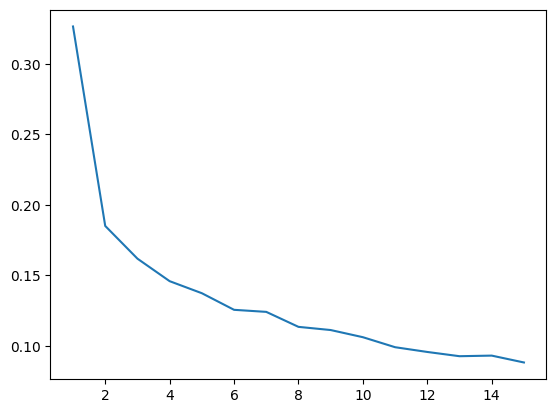

In [291]:
%matplotlib inline
import matplotlib.pyplot as plt

#print(epochs)
#print(np.arange(0, epochs+1))
#print(loss)
plt.plot(np.arange(1, epochs+1), loss)
plt.show()

## Evaluation (Accuracy, Precision, Recall)

We run our evaluation on our test data set so that we can measure our model's prediction performance on samples it has never seen before.  If we had high accuracy on the training set but not on the test set, that means we have overfit out model to our training data.

The three measures we'll use and their application are:

Accuracy: How many correct predictions are made by the model overall?

Precision: How many times was a guess for a specific number true? (Does it struggle with some numbers?)

Recall: How often could our model correctly identify a specific number when it saw it?

These can be calculated using True, False, Positive and Negative predictions.  
In the case of our multiclass classification we have to sum up all the possible predictions when considering each individual class.

For example, the classification of the number 2 we need to consider:
True Positives = Our model guessed 2 and the target was 2
True Negatives = Our model guessed *any number other than 2* and the target was indeed that number (Aka all correct predictions of numbers other than 2)
*True Negatives are actually not important to most of our calculations except when we sum all predictions, so we won't be needing to calculate it directly. They are just conceptually important to consider*
False Positives = Our model guessed 2 and the target was *any number other than 2*
False Negative = Our model guessed *any number other than 2* and the target was 2

This needs to be done for all 0-9 classes. 
With the values, we can calculate:

Accuracy = $TP + TN / TP + TN + FP + FN$
Precision = $TP / TP + FP$
Recall = $TP / TP + FN$

The cleanest way of doing this is with a confusion matrix, which will have the dimensions 10x10 to store cases between each of the 10 classes to eachother. 

In [283]:
#Running our neural network on the test data
testResult = myNN(x=test_data, mode='test')

#Converting the return probabilities to their predictions (the index of the highest %)
predictions = np.argmax(testResult, axis=1)

In [284]:
#Matrix initialization for 10 x 10 classes
nclasses = 10
confusionM = np.zeros((nclasses,nclasses), dtype=np.int32)

#Counting up predictions where row is the guess, column is the target
for i in range(0, len(predictions)):
    confusionM[predictions[i]][y_test[i]] += 1
    
#Rows(left) correspond to the model's guess, columns(top) are the target response
labels = list(range(0,nclasses))
print("\t","\t".join(str(e) for e in labels),"\n")
for i in range(0, len(confusionM)):
    print(f"{labels[i]}\t", '\t'.join(str(e) for e in confusionM[i]))

	 0	1	2	3	4	5	6	7	8	9 

0	 965	0	22	3	3	8	11	3	6	10
1	 0	1118	3	1	3	2	3	12	5	8
2	 0	2	905	9	2	0	1	13	1	1
3	 1	5	36	955	1	23	1	11	13	12
4	 0	0	12	1	903	1	8	4	3	18
5	 4	1	1	17	2	826	16	2	15	8
6	 4	2	12	1	9	12	911	0	7	1
7	 2	1	12	5	5	5	0	960	1	14
8	 4	6	28	17	14	13	7	10	922	35
9	 0	0	1	1	40	2	0	13	1	902


In [285]:
'''Functions to calculate the predictions
Accuracy = TP + TN / TP + TN + FP + FN (all results)
Precision = TP / TP + FP
Recall = TP / TP + FN'''

#The middle diagonal value of the matrix is where the prediction and target meet (correct guess)
def truePos(cFM):
    return np.diagonal(cFM)

#Summing by columns because rows represent the guesses per class
def falsePos(cFM):
    return np.sum(cFM, axis=1) - truePos(cFM)

#Now we sum over the rows (prediction), minus the correct guesses. This sums up all incorrect guesses per column (target)
def falseNeg(cFM):
    return np.sum(cFM, axis=0) - truePos(cFM)

TP = truePos(confusionM)
FP = falsePos(confusionM)
FN = falseNeg(confusionM)
print("For number values [0 1 2 3 4 5 6 7 8 9]")
print('TP:',TP)
print('FP:',FP)
print('FN:',FN)

#Accuracy per class
accuracies = TP / np.sum(confusionM, axis=1)
precisions = TP / (TP + FP)
recalls = TP / (TP + FN)

print('Overall(avg) Accuracy:',np.average(accuracies))
#Precision and Recall are meant to measure class specific performance, so averaging is not useful to us
print('\nClass\tPrecision\tRecall')
for i in range(0, len(labels)):
    print("%d:\t%.2f%%\t\t%.2f%%" % (labels[i], precisions[i]*100, recalls[i]*100))

For number values [0 1 2 3 4 5 6 7 8 9]
TP: [ 965 1118  905  955  903  826  911  960  922  902]
FP: [ 66  37  29 103  47  66  48  45 134  58]
FN: [ 15  17 127  55  79  66  47  68  52 107]
Overall(avg) Accuracy: 0.9369943522644268

Class	Precision	Recall
0:	93.60%		98.47%
1:	96.80%		98.50%
2:	96.90%		87.69%
3:	90.26%		94.55%
4:	95.05%		91.96%
5:	92.60%		92.60%
6:	94.99%		95.09%
7:	95.52%		93.39%
8:	87.31%		94.66%
9:	93.96%		89.40%


[0.0002613 0.0000073 0.0000213 0.0000725 0.0000001 0.0002283 0.
 0.9993552 0.0000038 0.0000502]


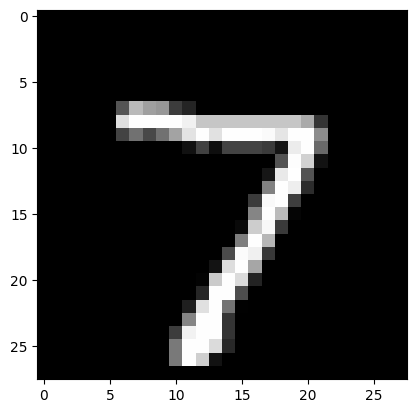

Target value: 7


In [286]:
#X_test, y_test

print(np.array_str(testResult[0], precision=7, suppress_small=True))
printDIGIT(X_test, y_test, 0)

In [287]:
pred = np.argmax(testResult, axis=1)
print(pred)
print(y_test)

different = []
for i in range(0, len(y_test)):
    if pred[i] != y_test[i]:
        different.append(i)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


Accuracy: 0.9367
Incorrectly classified numbers:  633
Error found at index 321. Pred:7 Target:2


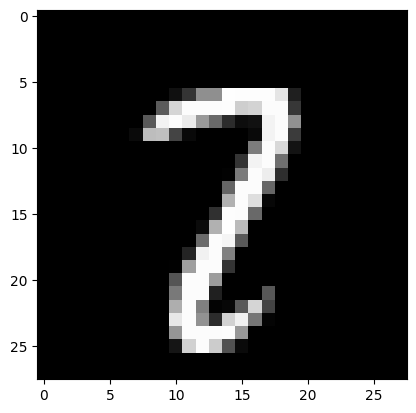

Target value: 2


In [288]:
print('Accuracy:', 1 - len(different)/len(y_test))
print('Incorrectly classified numbers: ', len(different))
errI = 20
print(f"Error found at index {different[errI]}. Pred:{pred[different[errI]]} Target:{y_test[different[errI]]}")
printDIGIT(X_test, y_test, different[errI])

Additional References used:
    *Assistance on some functions and layer dimensionality from a fellow grad Robert Carter.
    *https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    *https://shiffdag.medium.com/what-is-accuracy-precision-and-recall-and-why-are-they-important-ebfcb5a10df2
    *https://www.mage.ai/blog/definitive-guide-to-accuracy-precision-recall-for-product-developers
    *https://towardsdatascience.com/precision-and-recall-88a3776c8007#:~:text=Precision%20is%20calculated%20by%20dividing,was%20predicted%20as%20a%20positive.&text=Recall%20(or%20True%20Positive%20Rate,have%20been%20predicted%20as%20positive.